# GNNExplainer implementation using pytorch_geometric

In [1]:
import torch
import os.path as osp
import os
import sys

# Add the Max directory to the Python path to import models and dataset
sys.path.append('/u/shaswata/scratch/Learning/xAI_Drug/Max')

from dataset import Tox21Dataset

root_dir = '/u/shaswata/scratch/Learning/xAI_Drug/Max'
data_dir = os.path.join(root_dir,'data_1')
ds = Tox21Dataset(root=data_dir, task=['NR-AhR'])

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /u/shaswata/.local/lib/python3.9/site-packages/torch_scatter/_scatter_cpu.so: undefined symbol: _ZN5torch8autograd13_wrap_outputsERKSt6vectorIN2at6TensorESaIS3_EERKSt13unordered_setIPN3c1010TensorImplESt4hashISB_ESt8equal_toISB_ESaISB_EESJ_NS9_8ArrayRefINS9_8optionalIS3_EEEERKSt10shared_ptrINS0_4NodeEESt8functionIFS5_S5_S5_EE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /u/shaswata/.local/lib/python3.9/site-packages/torch_cluster/_graclus_cpu.so: undefined symbol: _ZN2at4_ops8randperm4callElN3c108optionalINS2_10ScalarTypeEEENS3_INS2_6LayoutEEENS3_INS2_6DeviceEEENS3_IbEE
  warnings.warn(f"An issue occurred while importi

# Load trained GIN model

In [2]:
from models import simpleGIN

do = 0.2
num_layer = 3
num_hidden = 64

model = simpleGIN(in_channels=ds[0].x.size(1), dim_h=num_hidden, out_channels=ds[0].y.size(0), num_layers=num_layer, dropout=do)
state_dict = torch.load(os.path.join(root_dir, "models/final/GIN_best.pth"))['net']
model.load_state_dict(state_dict)
model.to(device)

simpleGIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=67, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
  ))
  (GIN_layers): ModuleList(
    (0-1): 2 x GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): ReLU()
    ))
  )
  (classifier): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [3]:
model.eval()
with torch.no_grad():
    # Move data to the same device as the model
    x = ds[0].x.to(device)
    edge_index = ds[0].edge_index.to(device)
    print(model(x=x, edge_index=edge_index))

tensor([[ 1.0902, -0.5938]], device='cuda:0')


# Try GNNExplainer for one graph

In [4]:
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.loader import DataLoader

loader = DataLoader(ds, batch_size=1, shuffle=True)

In [5]:
model.eval()
with torch.no_grad():
    for batch in loader:
        # Move batch data to the same device as the model
        batch = batch.to(device)
        print(model(x=batch.x, edge_index=batch.edge_index))

tensor([[ 3.5695, -3.2792]], device='cuda:0')
tensor([[ 2.1580, -1.4872]], device='cuda:0')
tensor([[ 2.3286, -2.0576]], device='cuda:0')
tensor([[ 3.1279, -2.6596]], device='cuda:0')
tensor([[ 2.6130, -1.9319]], device='cuda:0')
tensor([[ 5.5430, -4.3171]], device='cuda:0')
tensor([[ 0.8805, -1.3334]], device='cuda:0')
tensor([[ 1.1337, -1.2287]], device='cuda:0')
tensor([[ 3.6987, -2.9130]], device='cuda:0')
tensor([[ 2.2171, -1.6033]], device='cuda:0')
tensor([[-0.2208,  0.0060]], device='cuda:0')
tensor([[ 7.9932, -6.9961]], device='cuda:0')
tensor([[ 2.7775, -2.7296]], device='cuda:0')
tensor([[ 1.5357, -1.3905]], device='cuda:0')
tensor([[ 2.3394, -1.9448]], device='cuda:0')
tensor([[ 3.0421, -2.2834]], device='cuda:0')
tensor([[ 4.8430, -3.8476]], device='cuda:0')
tensor([[-0.7145,  0.3317]], device='cuda:0')
tensor([[ 1.7148, -1.5718]], device='cuda:0')
tensor([[ 2.8712, -2.1385]], device='cuda:0')
tensor([[-1.2201,  0.8816]], device='cuda:0')
tensor([[ 1.8568, -1.6023]], devic

In [6]:
explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=20, lr=0.01),
        explanation_type='model',
        node_mask_type=None,  # Disable node mask to avoid dimension issues
        edge_mask_type='object',
        model_config=dict(
            mode='binary_classification',
            task_level='graph',
            return_type='raw'
        )
    )

In [7]:
# Move data to the same device as the model
x = ds[1].x.to(device)
edge_index = ds[1].edge_index.to(device)
target = ds[1].y.to(device)

explanation = explainer(x, edge_index, target=target)
print(explanation.edge_mask)

/u/shaswata/.local/lib/python3.9/site-packages/torch_geometric/explain/explainer.py:193: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


tensor([0.4005, 0.3019, 0.4436, 0.4380, 0.2931, 0.5713, 0.3448, 0.5674, 0.6713,
        0.4294, 0.4047, 0.4220, 0.2962, 0.6735, 0.6558, 0.4221, 0.4802, 0.6279,
        0.4029, 0.4451, 0.6520, 0.6426, 0.4325, 0.3893, 0.4529, 0.3778, 0.4058,
        0.5732, 0.3723, 0.4371, 0.4450, 0.4731], device='cuda:0')


In [8]:
explanation.visualize_graph()

Unable to connect to VS Code server: Error in request.
Error: connect ENOENT /run/user/73422/vscode-ipc-b54702ec-5ba0-4a7c-9001-bf30e2c90cad.sock
    at PipeConnectWrap.afterConnect [as oncomplete] (node:net:1636:16) {
  errno: -2,
  code: 'ENOENT',
  syscall: 'connect',
  address: '/run/user/73422/vscode-ipc-b54702ec-5ba0-4a7c-9001-bf30e2c90cad.sock'
}
Unable to connect to VS Code server: Error in request.
Error: connect ENOENT /run/user/73422/vscode-ipc-b54702ec-5ba0-4a7c-9001-bf30e2c90cad.sock
    at PipeConnectWrap.afterConnect [as oncomplete] (node:net:1636:16) {
  errno: -2,
  code: 'ENOENT',
  syscall: 'connect',
  address: '/run/user/73422/vscode-ipc-b54702ec-5ba0-4a7c-9001-bf30e2c90cad.sock'
}
xdg-open: no method available for opening 'graph.gv.pdf'


In [9]:
explanation.get_explanation_subgraph()

Explanation(edge_mask=[32], prediction=[1, 2], target=[2], x=[15, 67], edge_index=[2, 32])

## Generate Fidelity Curve for GNNExplainer

In [16]:
from torch_geometric.explain.metric import fidelity
import numpy as np

topk_list = [1, 5, 10, 15, 20, 30, 40, 50]
result_summary_GIN =[]

for topk in topk_list:
    print(f'Topk={topk}, Train GNNExplainer')
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=1, lr=0.003),
        explanation_type='phenomenon',
        edge_mask_type='object',
        model_config=dict(
            mode='binary_classification',
            task_level='graph',
            return_type='raw'
        ),
        threshold_config=dict(threshold_type='topk', value=topk)
    )

    # GNNExplainer trains automatically during explanation generation
    # No manual training loop is needed
    
    fidp_list = []
    fidm_list = []
    for i in range(len(ds)):
        # Move data to device
        x = ds[i].x.to(device)
        edge_index = ds[i].edge_index.to(device)
        target = ds[i].y.to(device)
        
        explanation = explainer(x, edge_index, target=target)
        fidp, fidm = fidelity(explainer, explanation)
        fidp_list.append(fidp)
        fidm_list.append(fidm)
    
    print(f'Result: fidelity_plus={np.mean(fidp_list):.4f}, fidelity_minus={np.mean(fidm_list):.4f}')
    result_summary_GIN.append({
        'method': "GNNExplainer",
        'topk': topk,
        'fidp': np.mean(fidp_list),
        'fidm': np.mean(fidm_list)
    })

Topk=1, Train GNNExplainer
Result: fidelity_plus=0.0142, fidelity_minus=0.1056
Topk=5, Train GNNExplainer
Result: fidelity_plus=0.0142, fidelity_minus=0.1056
Topk=5, Train GNNExplainer
Result: fidelity_plus=0.0362, fidelity_minus=0.1056
Topk=10, Train GNNExplainer
Result: fidelity_plus=0.0362, fidelity_minus=0.1056
Topk=10, Train GNNExplainer
Result: fidelity_plus=0.0580, fidelity_minus=0.1056
Topk=15, Train GNNExplainer
Result: fidelity_plus=0.0580, fidelity_minus=0.1056
Topk=15, Train GNNExplainer
Result: fidelity_plus=0.0715, fidelity_minus=0.1056
Topk=20, Train GNNExplainer
Result: fidelity_plus=0.0715, fidelity_minus=0.1056
Topk=20, Train GNNExplainer
Result: fidelity_plus=0.0832, fidelity_minus=0.1055
Topk=30, Train GNNExplainer
Result: fidelity_plus=0.0832, fidelity_minus=0.1055
Topk=30, Train GNNExplainer
Result: fidelity_plus=0.0985, fidelity_minus=0.1053
Topk=40, Train GNNExplainer
Result: fidelity_plus=0.0985, fidelity_minus=0.1053
Topk=40, Train GNNExplainer
Result: fidelit

In [ ]:
result_summary_GIN

In [ ]:
# Placeholder for results - will be populated after running the fidelity analysis
# result_summary_GIN = [{'method': 'GNNExplainer',
#   'topk': 1,
#   'fidp': np.float64(0.0),
#   'fidm': np.float64(0.0)},
# ... (results will be populated after running the analysis)
# ]

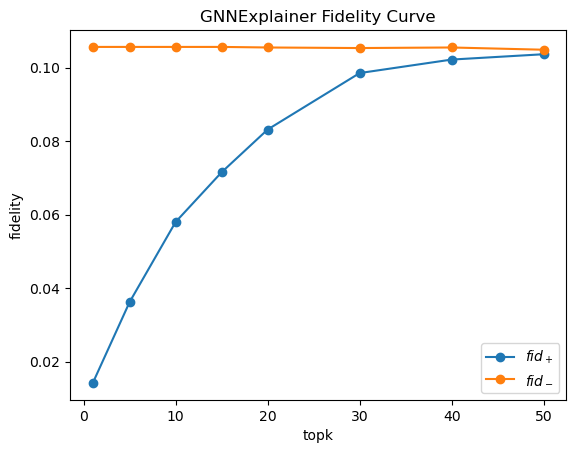

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

gnnExplainer = pd.DataFrame(result_summary_GIN)
plt.plot(gnnExplainer['topk'], gnnExplainer['fidp'], 'o-', label=r'$fid_+$')
plt.plot(gnnExplainer['topk'], gnnExplainer['fidm'], 'o-', label=r'$fid_-$')
plt.xlabel('topk')
plt.ylabel('fidelity')
plt.title('GNNExplainer Fidelity Curve')
plt.legend()
plt.show()